In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
# si vous travailler sur votre machine local

# tweets_df = pd.read_json('../input/iphone-11-tweets-fr.json', lines=True)
# tweets_df.head(3)

In [7]:
# si vous travailler sur Microsoft Azure

# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '6b3604b3-4873-43ba-a9f8-073a8c86ae0d'
resource_group = 'pfe'
workspace_name = 'pfe-workspace'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='iphone11_tweets_fr')
tweets_df = dataset.to_pandas_dataframe()
tweets_df.head(3)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,lang,media,quotedTweet,mentionedUsers
0,https://twitter.com/DLessay/status/13450795319...,2021-01-01 18:48:45,@MartinFayulu Vieux na iphone 11 pona image ya...,@MartinFayulu Vieux na iphone 11 pona image ya...,1345079531917471749,None,None,None,fr,None,None,None
1,https://twitter.com/amelwltr/status/1345076458...,2021-01-01 18:36:32,c bon j'ai commandé l'iphone 11 🥵,c bon j'ai commandé l'iphone 11 🥵,1345076458105016321,None,None,None,fr,None,None,None
2,https://twitter.com/enbrrrr_/status/1345076206...,2021-01-01 18:35:32,"Eh les amis, je souhaite un iphone 11 merci, c...","Eh les amis, je souhaite un iphone 11 merci, c...",1345076206383857664,None,None,None,fr,None,None,None


## 1. Exploration des données

Dans cette étape je vais explorer les tweets, on peut noter que notre source de données dispose plus de 100 mille tweets, ainsi chaque tweets et caractérisé par 21 colomnes.

In [8]:
tweets_df.shape

(111748, 12)

In [9]:
tweets_df.columns

Index(['url', 'date', 'content', 'renderedContent', 'id', 'user', 'outlinks',
       'tcooutlinks', 'lang', 'media', 'quotedTweet', 'mentionedUsers'],
      dtype='object')

Ce qui nous interesse le plus c'est la colomne `content` qui contien le contenu du tweet, donc on peux suprimer toute les autres colmnes, à noter que la colmne `renderedContent` est identique à la colomne `content`.

In [10]:
# garder que les colonnes importantes
cols = ['date', 'content', 'lang']
tweets_df = tweets_df[cols]

In [11]:
# pour etre sur que tout les tweets sont en français
tweets_df = tweets_df[tweets_df['lang'] == 'fr']
tweets_df['lang'].unique()

array(['fr'], dtype=object)

Pour vérifier l'évolution des tweets au fil du temps en utilisant la colomne `date`.

In [12]:
# garder que la date et supprimer l'heure
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

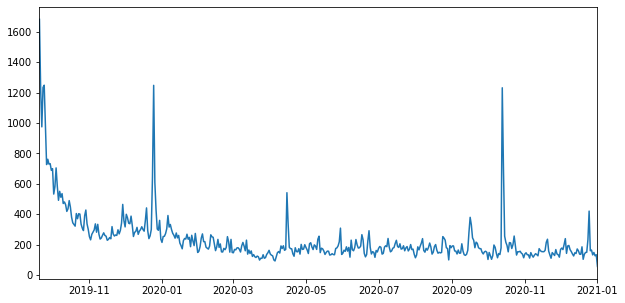

In [13]:
tweets_df['date'].value_counts().plot(kind='line', figsize=(10, 5))

plt.show()

On remarque que le nombre de tweets a atteint son maximum en septembre 2019, qui est le mois de la date de sortie de l'iPhone 11. Et le plus intéressant est qu'après un an, le nombre de tweets a encore augmenté en novembre 2020, qui est la date de sortie du nouvel iPhone 12, les gens comparaient peut-être les deux produits.

In [14]:
# supprimer les tweets dupliqués, 1K ont été supprimés

tweets_df = tweets_df.sort_values("content") 
  
# dropping ALL duplicte values 
tweets_df = tweets_df.drop_duplicates(subset ="content", keep = 'first')

## 2. Pré-traitement des tweets
Maintenant, après avoir préparé les tweets, nous pouvons commencer la phase de prétraitement afin de pouvoir nettoyer les tweets spécifiquement pour la phase d'identification du sujet. 
Pour des raisons de computation, je ne ferai des expériences que sur une partie des données `(15%)` afin de gagner du temps. Une fois que nous aurons validé le pipeline de prétraitement, je l'appliquerai à l'ensemble des données originales.

In [15]:
# selectionner aléatoirement 15% des tweets

# data = tweets_df['content'].sample(frac=0.15)
# len(data)

# je vais opter pour une autre stratégie
# au lieu de séléctionner un ensemble de tweets aléatoires,
# je vais séléctionner un ensemble de tweets d'un intervalle de temps, 
# qui sont les trois premiers mois après la date de sortie de l'iPhone

import datetime

last_date = datetime.date(2019, 12, 31) # le 31 Décembre 2019
data = tweets_df[tweets_df['date'] < last_date]['content']

In [16]:
ads_words = [
    'concours', 'jeuconcours', 'giveaway',
    '#gagne' ,'#gangner', 'promo', 'promotion', 'publicité',
    'contest', '#ad', '#pub', '#réduction']

data = data[~data.str.contains('|'.join(ads_words), case=False)]

### 2.1 Importer les packages
Les paquets de base utilisés dans ce tutoriel sont `re`, `gensim`, `spacy` et `pyLDAvis`. En outre, nous utiliserons également `matplotlib`, `numpy` et `pandas` pour le traitement et la visualisation des données qui sont déja importés. 

pour le model du spacy dédié à la langue française, exectutez cette commande sur votre terminal conda:  
`python -m spacy download fr_core_news_sm`  

pour importer le model: `spacy.load('fr_core_news_sm')`

In [17]:
import re
import spacy
from gensim.utils import tokenize

import json

from io import StringIO
from html.parser import HTMLParser

from collections import Counter 

# pour supprimer les emojis
# ce package est capable de remplacer les emojis avec leur signification en text BEAST!!!
#import demoji
#demoji.download_codes()

In [18]:
# fonction pour supprimer les symbols HTML

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    '''
    input, output: string
    '''
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [19]:
# NOTE: gensim tokenizer delete emojis, punctuations, and symbols
# HOWEVER: words like queue de cheva would become queue de cheval
# To Pass that we can use this flow: nltk.word_tokenize -> delete punctuations -> delete emojis

def tokenize_tweet(tweet):
    '''
    input: string (tweet)
    output: list of words
    '''
    tweet = tweet.lower()
    text_out = list(tokenize(tweet, deacc = True))
    return text_out

In [20]:
# remplacement des abréviations

with open('../input/abrivot_fr.json', encoding='utf-8') as f:
    abrivot = json.load(f)
    
def replace_abrivot(words):
    '''
    input, output: list of tokens
    '''
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return text_out

In [21]:
# lemmatization fonction, charger le model spacy pour la langue français

# si ça marche pas
#nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# essaye celle la
import fr_core_news_sm
nlp = fr_core_news_sm.load()

def lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''
    input, output: list of tokens
    '''
    text = " ".join(words)
    doc = nlp(text) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

In [22]:
# fonction générale pour le prétraitement

def tweets_preprocesser(tweets):
    all_tweets=[]
    for tweet in tweets:
        
        # supprimer les symboles HTML
        reformed = strip_tags(tweet)
        
        # supprimer les urls et les @mentions
        reformed = re.sub(r'(?:\@|https?\://)\S+', '', reformed)
        
        # tokenize (remove punctuation, chiffres, emojis)
        tokens = tokenize_tweet(reformed)
        
        # remplacer les abréviations
        tokens = replace_abrivot(tokens)
        
        # lemmatization
        tokens = lemmatization(tokens)
        
        tweet_cleaned = " ".join(tokens)
        all_tweets.append(tweet_cleaned)
    all_text = ' '.join(all_tweets)
    all_words = all_text.split()
    return all_tweets, all_words

In [23]:
%%time

all_tweets, all_words = tweets_preprocesser(data)
all_tweets[:1]

CPU times: user 5min 11s, sys: 511 ms, total: 5min 12s
Wall time: 5min 11s


['actualite apple iphon juste prix smartphone tim anglohatech']

In [24]:
# préparer la liste des mots vide, 626 mots
# importer les mots vides de la langue Française

stop_words = nlp.Defaults.stop_words

# fonction pour séléctionner les n mots le plus pertinants
# pour les rajouter dans la liste des mots vides

def select_top_words(bag_words, n_words=30):
    
    # Count all the words using Counter Method
    count_words = Counter(all_words)
    total_words=len(all_words)
    sorted_words=count_words.most_common(total_words)
    
    # select the n_words top words
    top_words = [word[0] for word in sorted_words[:n_words]]
    return top_words

# mettre à jour la liste des mots vides avec les 30 mots les plus fréquents
stop_words.update(select_top_words(all_words))

In [25]:
# supprimer les mots vides
def remove_stopwords(texts):
    
    tokens = [[word for word in doc.split() if word not in stop_words] for doc in texts]
    all_tweets = [' '.join(doc) for doc in tokens if len(doc) > 1]
    all_words = (' '.join(all_tweets)).split()
    
    return all_tweets, all_words

all_tweets, all_words = remove_stopwords(all_tweets)

La suppression des documents non valables (données bruits). Par exemple les publicités, les tweets qui n'ont pas de relation avec le produit.  

Les documents relatifs au bruit sont définis comme ceux qui ne comportent aucun mot-clé lié au produit (iphone 11).